# Portfolio Optimization

by *`Domenico Picone`*

---

In this notebook, I answer a classical Porfolio Optimization question:

IS THE VALUE OF THE SLOPE OF THE TANGENT LINE AT THE TANGET POINT THE SAME AS THE VALUE OF THE SHARPE RATIO? 

---
### Plan

The way I plan to answer this question is as follows:
1. Import from yahoo, prices of 5 entities, and assume that they are the only available names to invest in
2. Randomly create 1,000 different combinations of those five names assuming that they are the 1,000 different asset allocations managed by 1,000 different managers. I am also assuming that no short position is allowed
3. From those 1,000 portfolios, build the efficient frontier
4. and select that portfolio, on the efficient frontier, with a desired level of risk (standard devation).
5. Show why this portfolio is at the "minimum" and what minimum means.
6. Add the Capital Market Line and show that the beta is indeed the Sharpe Ratio.
7. Following, spend a bit of time showing that none of equity prices exhibits a normal distribution behaviour and the historic correlation between the names has been very volatile, and so we cannot assume it is a stable quantity.


---
### Contents

I break the notebook into separate steps for easy of reading, and provide relative links for a a quick navigation.

* [Step 0](#step0): Python libraries required for the analysis
* [Step 1](#step1): Importing dataset from yahoo
* [Step 2](#step2): Creating all the available portfolios
* [Step 3](#step3): The Efficient Frontier
* [Step 4](#step4): Minimize the Variance
* [Step 5](#step5): The Efficient Frontier
* [Step 6](#step6): Capital Market Line
* [Step 7](#step7): Sharpe Ratio
* [Step 8](#step8): Limitations

<a id='step0'></a>
## Python libraries required for the analysis

In [1]:
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as sco
from scipy.interpolate import splev, splrep # for cubic splines
import scipy.interpolate as sci

from pandas_datareader import data as pdr # to load data from yahoo
%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<a id='step1'></a>
## Step 1 - Importing dataset from yahoo

In [2]:
# Equity prices for the following names 
#1: DAX Stock Market Index, symbol ^GDAXI
#2: S&P 500 Market Index, symbol ^GSPC
#3: Microsoft Corp, symbol MSFT
#4: SPDR Gold Shares, symbol GLD
#5: Deutsche Bank AG, symbol DB

symbols = ['^GDAXI', '^GSPC', 'MSFT', 'GLD','DB']
noa     = len(symbols) # The number of names 

In [3]:
# prices for the equity names above are imported and stored into a pandas dataframe. I also remove rows where na is present
data = pd.DataFrame()
for sym in symbols:
    data[sym] = pdr.get_data_yahoo(sym, start='1/1/2014',  end='25/10/2019')['Adj Close']
    
data.columns = symbols
data = data.dropna()    

### Check the data is correct

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


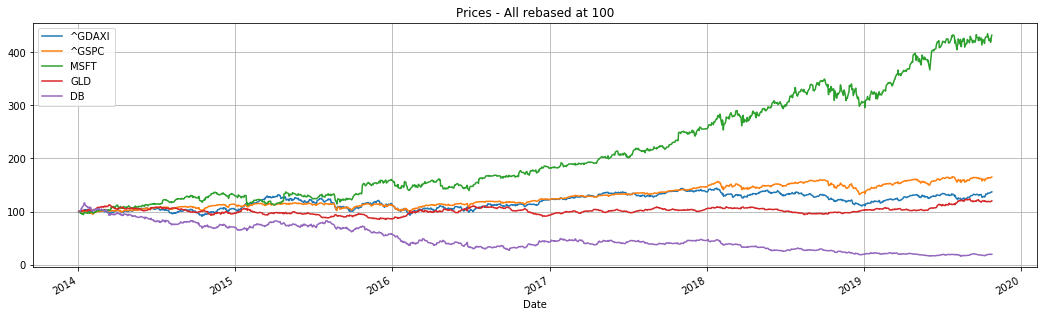

In [4]:
(data / data.ix[0] * 100).plot(figsize=(18, 5), grid=True)
plt.title("Prices - All rebased at 100")
plt.show()

In [5]:
# calculate the daily returns
rets = np.log(data / data.shift(1))

In [6]:
# and the annualised mean
rets.mean() * 252

^GDAXI    0.055547
^GSPC     0.087990
MSFT      0.257111
GLD       0.032362
DB       -0.286568
dtype: float64

In [7]:
# daily variances
rets.var()

^GDAXI    0.000127
^GSPC     0.000070
MSFT      0.000207
GLD       0.000068
DB        0.000538
dtype: float64

In [8]:
# daily covariances
rets.cov()

,^GDAXI,^GSPC,MSFT,GLD,DB
^GDAXI,0.000127,0.000051,0.000059,-0.000022,0.000140
^GSPC,0.000051,0.000070,0.000088,-0.000010,0.000104
MSFT,0.000059,0.000088,0.000207,-0.000013,0.000105
GLD,-0.000022,-0.000010,-0.000013,0.000068,-0.000035
DB,0.000140,0.000104,0.000105,-0.000035,0.000538


In [9]:
# annualised covariances
rets.cov() * 252

,^GDAXI,^GSPC,MSFT,GLD,DB
^GDAXI,0.031964,0.012819,0.014889,-0.005547,0.035349
^GSPC,0.012819,0.017555,0.022100,-0.002623,0.026094
MSFT,0.014889,0.022100,0.052186,-0.003355,0.026529
GLD,-0.005547,-0.002623,-0.003355,0.017238,-0.008845
DB,0.035349,0.026094,0.026529,-0.008845,0.135466


In [10]:
# and correlation matrix
rets.corr()

,^GDAXI,^GSPC,MSFT,GLD,DB
^GDAXI,1.000000,0.541148,0.364546,-0.236294,0.537196
^GSPC,0.541148,1.000000,0.730157,-0.150760,0.535079
MSFT,0.364546,0.730157,1.000000,-0.111875,0.315523
GLD,-0.236294,-0.150760,-0.111875,1.000000,-0.183032
DB,0.537196,0.535079,0.315523,-0.183032,1.000000


<a id='step2'></a>
## Step 2 - Creating all the available portfolios

### The Basic Theory

The theory is that I invest into the five available names, according to some weights (summing to 1). Once the weights are set, I can calulated the expected return and standard deviation of my portfolio as follows. 

In [11]:
np.random.seed(1000) # this ensure that e are all calculating the same random sequence
print (noa) # let's check that the number if 5
weights = np.random.random(noa)
weights /= np.sum(weights)
print (weights)

5
[0.21265006 0.03741833 0.30918134 0.15688443 0.28386584]


In [12]:
# The expected portfolio return
np.sum(rets.mean() * weights) * 252

0.01832845037354813

In [13]:
# The expected portfolio variance
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.028436312937456517

In [14]:
# The portfolio standard deviation
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.16863069986647305

Now I create those 1,000 different portfolios. Each portfolio (asset manager) invest only in those five names and it is different from all the other portfoios. To ensure that they are all different, their respective weights into the five names are randomly calculated.

In [15]:
prets = []
pvols = []
psharp = []

for p in range (1000):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    ret = np.sum(rets.mean() * weights) * 252
    sd =  np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

    prets.append(ret)
    pvols.append(sd)
    psharp.append(ret/sd)
    
    
prets = np.array(prets)
pvols = np.array(pvols)
psharp = np.array(psharp)

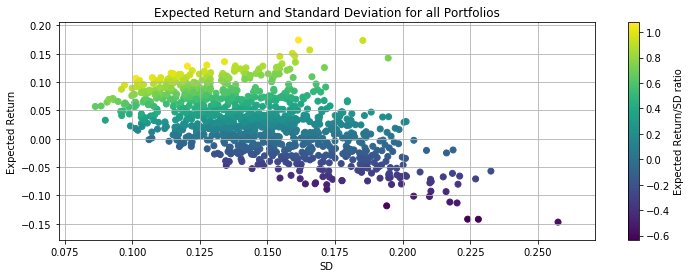

In [16]:
plt.figure(figsize=(12, 4))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('SD')
plt.ylabel('Expected Return')
plt.colorbar(label='Expected Return/SD ratio')
plt.title("Expected Return and Standard Deviation for all Portfolios")
plt.show()

<a id='step3'></a>
## Step 3 - The Efficient Frontier

Now I need a function that I can use into a minimization routine. I want to create a flexible tool which allows me to select what I want to minimize given a certain condition. For example, I may want to select amongst all the portfolios with the same Standard Deviation, the portfolio with the largest expected return. Alternatively, I may want to select the portfolio with the minimum standard deviation. Or more, given a return target, the one with the minimum standard deviation

In [17]:
# This is my flexible function
# It return an numpy array of return, sd and sharpe ratio
def statistics(weights):
    ''' Return portfolio statistics. '''
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [18]:
# Let's test the above function, and let's try MAXIMIZE the Ratio of the Expected Return over the SD
# The function below returns the sharpe ratio from statistics. And I need with a minus sign infront
def min_func_sharpe(weights):
    return -statistics(weights)[2]

We need now to add the equality conditions in connection to the portfolio weights. The sum of the weights must be equal to 1.

In python we do this by creating a lambda function and set the sum of the weights minus 1 is zero

In [19]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

We also need the boundary conditions on the weights, being from 0 to 1

In [20]:
bnds = tuple((0, 1) for x in range(noa))

In [21]:
# let's check the bundaries are corerctly parsed as a tuple
print (bnds)

((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))


In [22]:
# THese are the starting conditions
noa * [1. / noa,]

[0.2, 0.2, 0.2, 0.2, 0.2]

In [23]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',bounds=bnds, constraints=cons)

Wall time: 53.4 ms


In [24]:
opts

     fun: -1.1862469285190387
     jac: array([ 3.08989733e-02,  1.17272764e-01, -3.33473086e-04,  5.92336059e-04,
        2.67143382e+00])
 message: 'Optimization terminated successfully.'
    nfev: 50
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.00000000e+00, 0.00000000e+00, 6.39802994e-01, 3.60197006e-01,
       1.29266947e-15])

In [25]:
# this is teh Jacobian
np.round(opts['jac'],2)

array([ 0.03,  0.12, -0.  ,  0.  ,  2.67])

In [26]:
# and the solution weights is
np.round(opts['x'],4) #.round(10)

array([0.    , 0.    , 0.6398, 0.3602, 0.    ])

In [27]:
# with the following expected return, expected sd, and their ratio 
Sharperesults = statistics(opts['x']).round(3)
print("{:10s} {:22s} {:20s}".format('Expected Return', 'Standard Deviation', 'ER/SD Ratio'))
print ( 50* "-")

print("{:3.5f} {:15.5f} {:22.5f}".format(Sharperesults[0], Sharperesults[1], Sharperesults[2] ))

Expected Return Standard Deviation     ER/SD Ratio         
--------------------------------------------------
0.17600         0.14800                1.18600


In [28]:
# It looks like this is ok. I can say I can achieve a better ER/SD ratio than any other portfolios created above 
# The maximum ER/SD ratio for all the portfolios is 
print (np.round(np.max(psharp),4))

1.0776


In [29]:
# which is achieved with this Expected return and SD
indexdom = np.where(psharp == np.max(psharp))
print ("Exected Return",np.round(prets[indexdom][0],4))
print ("SD",np.round(pvols[indexdom][0],4))

Exected Return 0.174
SD 0.1615


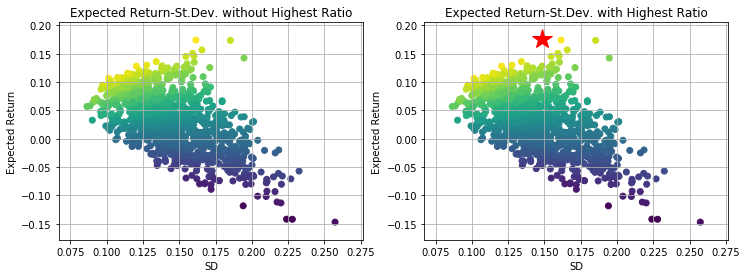

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(pvols, prets, c=prets / pvols, marker='o')
ax1.grid(True)
ax1.set_xlabel('SD')
ax1.set_ylabel('Expected Return')
ax1.set_title("Expected Return-St.Dev. without Highest Ratio")

ax2.scatter(pvols, prets, c=prets / pvols, marker='o')
ax2.grid(True)
ax2.set_xlabel('SD')
ax2.set_ylabel('Expected Return')
ax2.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],'r*', markersize=20.0)
ax2.set_title("Expected Return-St.Dev. with Highest Ratio")
plt.show()

<a id='step4'></a>
## Step 4 -  Minimize the Variance

I can now move to minimize the variance. In doing so I will select that portfolio with the minimum level of variance  

In [31]:
# we minimise the variance
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

In [32]:
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP',bounds=bnds, constraints=cons)

In [33]:
# Let's print the output of the minimization
print (optv)

     fun: 0.006772357654686988
     jac: array([0.01356903, 0.01361507, 0.01668759, 0.01348784, 0.02054646])
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([0.15978599, 0.34507738, 0.        , 0.49513663, 0.        ])


In [34]:
# Let's check the constraint is met. The sum of the weights must be one
np.sum(optv['x'])

1.0

In [35]:
optv

     fun: 0.006772357654686988
     jac: array([0.01356903, 0.01361507, 0.01668759, 0.01348784, 0.02054646])
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([0.15978599, 0.34507738, 0.        , 0.49513663, 0.        ])

In [36]:
#and finally the weights for each of the five equities are below
optv['x'].round(5)

array([0.15979, 0.34508, 0.     , 0.49514, 0.     ])

In [37]:
results = statistics(optv['x'])
print("{:10s} {:25s} {:20s}".format('Ex Return', 'Standard Deviation', 'ER/SD Ratio'))
print ( 50* "-")

print("{:3.5f} {:15.5f} {:22.5f}".format(results[0], results[1], results[2] ))

Ex Return  Standard Deviation        ER/SD Ratio         
--------------------------------------------------
0.05526         0.08229                0.67152


<a id='step5'></a>
## Step 5 -  The Efficient Frontier

The problem of the efficient frontier is to derive all the "optimal" portfolios. They are all the portfolios with the minimum variance for a given target of return, or all the portfolios with the maximum return for a given target of standard deviation 

The way I do this is by fixing a return (we call it 'tret' as per target return), and derive for each level, the portfolio weights which ensure the mnimum variance.

The algo above need to be changed as I have to introduce an additional constraint, namely the target return level, in addition to the sum of the portfoio weight being qual to 1.

In [38]:
# constraints and boundaries
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [39]:
# I want now to minimize the variance, so no negative sign
def min_func_port(weights):
    return statistics(weights)[1]

In [40]:
# and ready to go.
# the level of returns are assumed to go from 0 to 25% 

trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

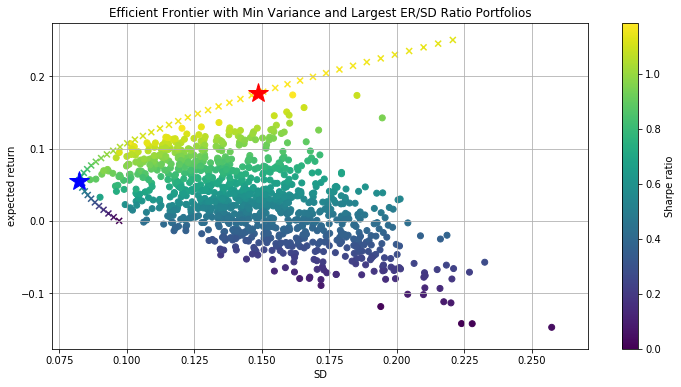

In [41]:
plt.figure(figsize=(12, 6))
# random portfolio composition
plt.scatter(pvols, prets,c=prets / pvols, marker='o')
# efficient frontier
plt.scatter(tvols, trets,c=trets / tvols, marker='x')
# portfolio with highest Sharpe ratio            
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],'r*', markersize=20.0)
# minimum variance portfolio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],'b*', markersize=20.0)
plt.grid(True)
plt.xlabel('SD')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.title("Efficient Frontier with Min Variance and Largest ER/SD Ratio Portfolios")
plt.show()

I have identified the portfolio with the minimum standard deviation. The blue start.

I have also identified the portfolio with the maximum sharpe ratio. The red start.

All the portfolios on the efficient frontier are clearly all "efficient" in the snse that for the same level of standard deviation, they achieve the highest possible level of expected return  

The question now I will answer is: do all portfolio on the efficient frontier have the same sharpe ratio?

The answer is NO, and I will show why this is via another model, called the Capital Market Line 

<a id='step6'></a>
## Step 6 -  Capital Market Line

I will create a CM "straight" line which is tangent to the efficient frontier. The tanget point is the point with the "largest" sharpe ratio. 

There is Only One Point on the efficient frontier 

Let's plot again the efficient frontier 

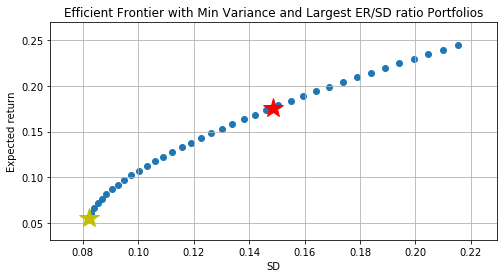

In [42]:
ind    = np.argmin(tvols)
indMax = np.argmax(tvols)
evols = tvols[ind:indMax]
erets = trets[ind:indMax]
plt.figure(figsize=(8, 4))
plt.scatter(evols, erets,marker='o')
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],'r*', markersize=20.0)
            # portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],'y*', markersize=20.0)
            # minimum variance portfolio
plt.grid(True)
plt.xlabel('SD')
plt.ylabel('Expected return')

plt.title("Efficient Frontier with Min Variance and Largest ER/SD ratio Portfolios")
plt.show()

I want to complete the incomplete data between the various dots. I will do this via splining the dots

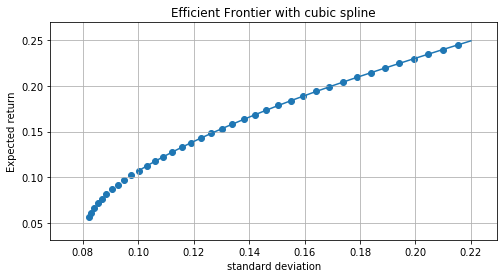

In [43]:
# Cubic spline betweem 13% and 22%, as I do not need below 13%

# Below you can read the min and max varianceaccording to the "Efficient Frontier"
#print(evols.shape)
#print(erets.shape)
#print (ind)
#print (indMax)
#print (tvols[ind])
#print (tvols[indMax])

tck = splrep(evols, erets)
plt.figure(figsize=(8, 4))
plt.scatter(evols, erets,marker='o')
x2 = np.linspace(0.10, .22, 1000)
y2 = splev(x2, tck)
plt.plot(x2, y2)
plt.grid(True)
plt.xlabel('standard deviation')
plt.ylabel('Expected return')
plt.title("Efficient Frontier with cubic spline")
plt.show()

To calculate the "tangent pont" I need to set the efficient frontier as a function of x, and the derivative of f with respect to x.

x goes from 0.13 to 0.22 as done above with the cubic spline 

In [44]:
# The f(x) is known via its spline implementation. We know its spline implemantation at each point x of its domain
def f(x):
    ''' Efficient frontier function (splines approximation). '''
    return splev(x, tck, der=0)
def df(x):
    ''' First derivative of efficient frontier function. '''
    return splev(x, tck, der=1)

I am looking now for a straight line which passes through the riskless asset on the y coordinate and it is tangent to the efficient frontier. At the tangent point the slope is the same.

The value of the slope at the tangent point is the Sharpe Ratio

Let's now set the value for the Risk Less Asset Rate  

In [45]:
RiskLessAssetReturn = 0.02

In [46]:
def equations(p, rf=RiskLessAssetReturn):    
    eq1 = rf - p[0]                 # this is the condition of the riskless asset rate, 
    eq2 = rf + p[1] * p[2] - f(p[2])# the efficient frontier and the CML at the tangent point must have the same value 
    eq3 = p[1] - df(p[2])           # the CML slope and the derivative of the efficient frontier at the tangent point 
                                    # must have the same value
    return eq1, eq2, eq3
# p[0] is the intercept (the riskless asset)
# p[1] is the slope
# p[2] is x point where the derivative of efficient frontier is the same as the slope of the CML 

In [47]:
# let's pass some initial conditions and solve the system of equations!
opt = sco.fsolve(equations, [0.01, 0.5, 0.15])

Let's check! we expect: 

1 - p0 to be the same as the riskless asset.

2 - p1 to be the sharpe ratio. We still have to prove this.

3 - p2 is the tanget point x where the efficient frontier touches CML 

In [48]:
print(opt[0])
print(opt[1])
print(opt[2])

0.02
1.0592967773018536
0.16895367792935348


In [49]:
# We also check that the three conditions above are satisfied at the solution points
np.round(equations(opt), 8)

array([ 0., -0.,  0.])

In [50]:
# Check on the riskless asset
print (opt[0])
print (RiskLessAssetReturn)

0.02
0.02


In [51]:
# Check the values of the Efficient Frontier is the same as the CML at the tangent point x
print (f(opt[2]))
print (RiskLessAssetReturn + df(opt[2])*opt[2])

0.19897208654386356
0.19897208654385654


<a id='step7'></a>
## Step 7 - Sharpe Ratio

There is inly one point on the efficient frontier with the "best" Sharpe Ratio

MY STATEMENT IS THAT THE VALUE OF THE SLOPE OF THE TANGENT LINE AT THE TANGET POINT IS THE SAME AS THE VALUE OF THE SHARPE RATIO.
PREVIOUSLY I FOUND THE PORTFOLIO WITH THE BEST EXPECTED RETURN / SD RATIO. 
LET'S RERUN THE SAME EXERCISE WHERE THIS TIME, INSTEAD OF EXPECTED RETURNS AND STANDARD DEVIATION I USE EXCESS RETURNS AND STANDARD DEVIATION
TO DO SO I REMOVE FROM THE EXPECTED RETURNS THE RISKLESS ASSET RETURN.
I OPTIMIZE AND CALCULATE THE BEST SHARPE RATIO. 

In [52]:
# to find the portfolio with the maximum the sharpe ratio, 
# this time I modify the function used in the step "The Efficient Frontier". But all in one go, as we know what to do
def statistics_sharpe(weights):
    ''' Return portfolio statistics. '''
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252 -.02
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

def min_func_sharpe_2(weights):
    return -statistics_sharpe(weights)[2]

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
noa * [1. / noa,]
opts_2 = sco.minimize(min_func_sharpe_2, noa * [1. / noa,], method='SLSQP',bounds=bnds, constraints=cons)

Sharperesults_2 = statistics_sharpe(opts_2['x']).round(6)
print("{:10s} {:22s} {:20s}".format('Expected Return', 'Standard Deviation', 'Sharpe Ratio'))
print ( 50* "-")
print("{:3.5f} {:15.5f} {:22.5f}".format(Sharperesults_2[0], Sharperesults_2[1], Sharperesults_2[2] ))

Expected Return Standard Deviation     Sharpe Ratio        
--------------------------------------------------
0.17895         0.16893                1.05930


In [53]:
# The beta of the tangent line is
print("{:30s} {:52s}".format('Slope of the Tangent Line', 'Sharpe Ratio'))
print ( 45* "-")
print("{:3.5f} {:35.5f}".format(np.round(df(opt[2]),5),  Sharperesults_2[2] ))

Slope of the Tangent Line      Sharpe Ratio                                        
---------------------------------------------
1.05930                             1.05930


THE SHARPE RATIO VALUE IS EXACTLY THE SLOPE OF THE TANGENT LINE TO THE EFFICIENT FRONTIER!

In [54]:
#The value of the standard deviation corresponding to the largest sharpe ratio is the same as opt[2] calculated above
print("{:3.5f}".format(opt[2]))
print("{:3.5f}".format(Sharperesults_2[1]))

0.16895
0.16893


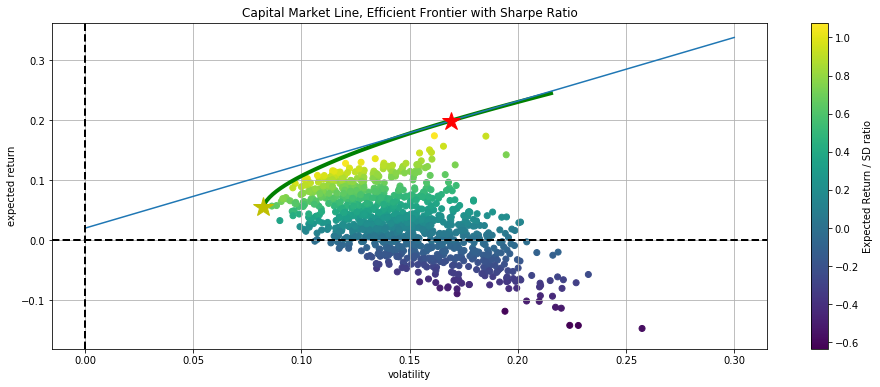

In [55]:
plt.figure(figsize=(16, 6))
# random portfolio composition
plt.scatter(pvols, prets, c=(prets) / pvols, marker='o')
# efficient frontier
plt.plot(evols, erets, 'g', lw=4.0)

cx = np.linspace(0.0, 0.3)
# capital market line
plt.plot(cx, opt[0] + opt[1] * cx, lw=1.5) 

# the sharpe ratio
plt.plot(opt[2], f(opt[2]), 'r*', markersize=19.0) 
 
# minimum variance portfolio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],'y*', markersize=20.0)

plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('volatility')
plt.ylabel('expected return')
plt.colorbar(label='Expected Return / SD ratio')
plt.title("Capital Market Line, Efficient Frontier with Sharpe Ratio")
plt.show()

<a id='step8'></a>
## Step 8 - Limitations

Returns are NOT normally distributed, they are very unstable over time and show very volatile correlations with other equity returns

1. The log returns of the equity prices are generally not normally distributed, instead they show a high degree of kurtosis. So using the standard deviation as a measure is incorrect
2. Also, the log returns of equity prices are themselves very unstable. 
3. The correlation between pairs of of log returns are also not stable.
4. As a consequence of 2 and 3, the period used to estimate average return and correlation are an important decision to make. Out of sample period portfolios with parameters estimated over in sample periods have performed very poorly, with very poor forecasting accuracy as well.   
5. In the next few charts, I am going to show the log returns of the DAX Stock Market Index, the S&P 500 Market Index (respectively the first and second symbol downloaded from yahoo, ^GDAXI' and '^GSPC'). I plot their log return hystograms and compare them against the normal distribution density. I continue by showing the rolling average log returns, and I close by illustraing their rolling correlations.
6. The log returns of all five stocks look more like to mean revert. Also, even on the short time scale I used, it is not clear whether the best asset is always the best asset. Even the worst asset (DB) posted the best returns in the first half of 2017.
7. An ALTERNATIVE is to perform short "look back" estmation periods, maybe of 12 months, when estimating the asset allocation weights, so to capture the momentum factor.

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_core.py:2246: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


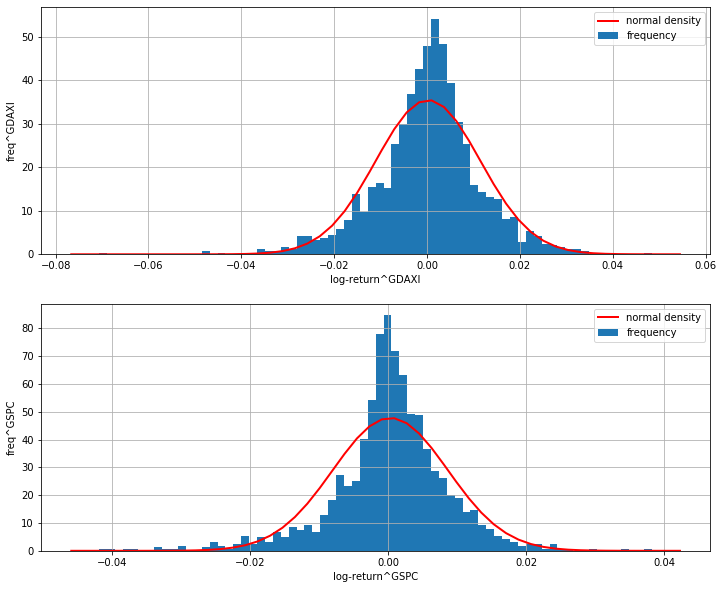

In [56]:
%matplotlib inline
plt.figure(figsize=(12, 10)) 

val = 0 
plt.subplot(211)
rets[symbols[val]].hist(bins=70, normed=True, label='frequency')
plt.grid(True)
plt.xlabel('log-return' + symbols[val])
plt.ylabel('freq' + symbols[val])
x = np.linspace(plt.axis()[0], plt.axis()[1])
plt.plot(x, scs.norm.pdf(x, loc=np.mean(rets[symbols[val]]), scale=np.std(rets[symbols[val]])),'r', lw=2.0, label='normal density')
plt.legend()

val = 1
plt.subplot(212)
rets[symbols[val]].hist(bins=70, normed=True, label='frequency')
plt.grid(True)
plt.xlabel('log-return' + symbols[val])
plt.ylabel('freq' + symbols[val])
x = np.linspace(plt.axis()[0], plt.axis()[1])
plt.plot(x, scs.norm.pdf(x, loc=np.mean(rets[symbols[val]]), scale=np.std(rets[symbols[val]])),'r', lw=2.0, label='normal density')
plt.legend()

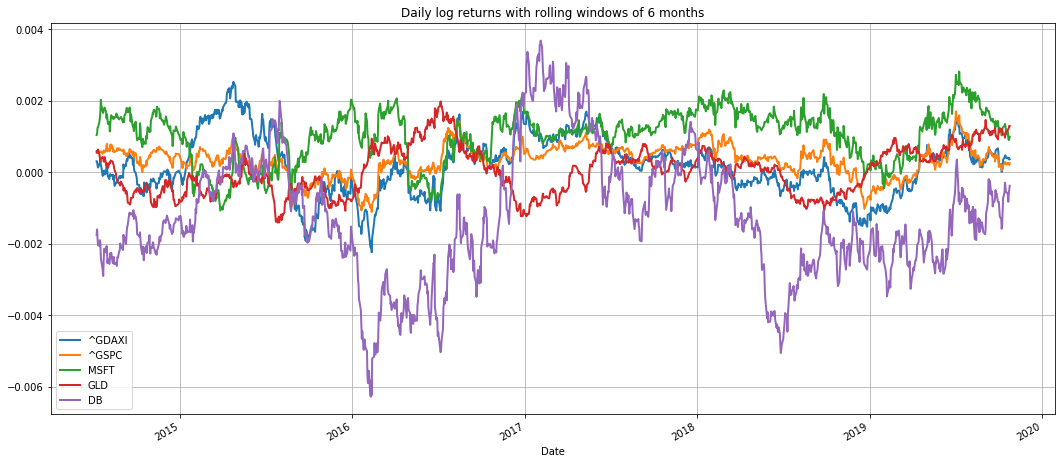

In [57]:
w = int(252/2.0)  # rolling window of 6 months
rets.rolling(int(w)).mean().plot(label='FTSE all share (close)', figsize=(18,8), grid=True,lw=2)
plt.title("Daily log returns with rolling windows of 6 months")
plt.show()

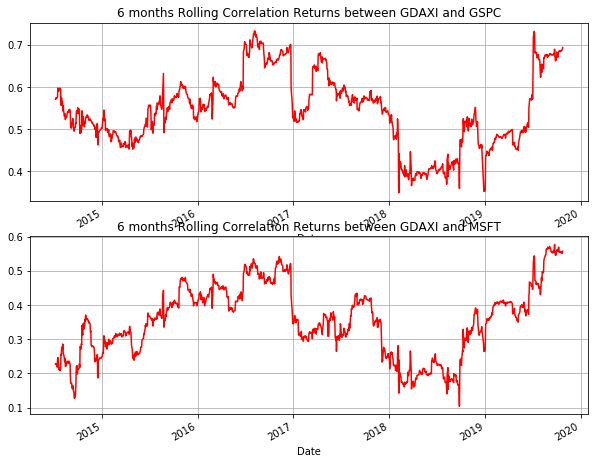

In [58]:
symbols = ['^GDAXI', '^GSPC', 'MSFT', 'GLD','DB']
rets['GDAXI_and_GSPC'] = rets[symbols[0]].rolling(w).corr(rets[symbols[1]])
rets['GDAXI_and_MSFT'] = rets[symbols[0]].rolling(w).corr(rets[symbols[2]])

plt.figure(figsize=(10, 8)) 

plt.subplot(211)
rets['GDAXI_and_GSPC'].plot(grid=True, style='r')
plt.title("6 months Rolling Correlation Returns between GDAXI and GSPC")

plt.subplot(212)
rets['GDAXI_and_MSFT'].plot(grid=True, style='r')
plt.title("6 months Rolling Correlation Returns between GDAXI and MSFT")

plt.show()
